# Predict Website Conversions Notebook 2 Data Prep and Modelling

For part 1 of this work please see Notebook 2

## Import Dataset and Libraries

In [157]:
#pip install lightgbm

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier

In [99]:
df_train = pd.read_csv("C:/Users/imoge/Projects/Datasets/CustomerPredictionTrain2.csv", index_col=False)
df_test = pd.read_csv("C:/Users/imoge/Projects/Datasets/CustomerPredictionTest.csv")

In [259]:
df_train.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [260]:
df_test.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

Issue to note is that we have a pre-split training and test set for this data, so we are likely to face a situation where we are encoding values that the encoder encounters values in the test set that it has not seen in the training set. We need to account for this when encoding or the encoder will fail

In [100]:
df_train.shape, df_test.shape

((5790, 22), (3693, 18))

## Data Preparation

In [101]:
df_train.head()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Administative_Duration/Page,Informational_Duration/Page,Product_Duration/Page
0,8568,0,0.00,0,0.00,2,0.00,0.20,0.20,0.00,...,1,1,3,1,Returning_Visitor,0,0,NaN,NaN,0.00
1,9207,1,5.00,0,0.00,2,15.20,0.00,0.04,0.00,...,1,1,6,3,Returning_Visitor,0,0,5.00,NaN,7.60
2,9321,0,0.00,0,0.00,3,0.00,0.20,0.20,0.00,...,1,1,3,4,Returning_Visitor,0,0,NaN,NaN,0.00
3,8955,4,54.80,0,0.00,3,20.26,0.00,0.03,0.00,...,1,1,3,2,Returning_Visitor,0,0,13.70,NaN,6.75
4,8180,0,0.00,0,0.00,4,39.80,0.00,0.05,0.00,...,1,1,1,3,New_Visitor,0,0,NaN,NaN,9.95


In [102]:
df_test.head()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,913,0,-1.00,0,-1.00,1,-1.00,0.00,0.07,0.00,0.00,Mar,2,2,7,1,Returning_Visitor,0
1,1863,0,-1.00,0,-1.00,1,-1.00,0.20,0.20,0.00,0.00,Feb,2,2,4,3,Returning_Visitor,0
2,1013,0,-1.00,0,-1.00,1,-1.00,0.20,0.20,0.00,0.00,May,2,10,5,1,Returning_Visitor,0
3,1311,0,-1.00,0,-1.00,1,-1.00,0.20,0.20,0.00,0.00,Feb,3,2,3,3,Returning_Visitor,0
4,649,0,-1.00,0,-1.00,1,-1.00,0.20,0.20,0.00,0.00,May,1,1,1,20,Returning_Visitor,0


In [103]:
# Drop the extra columns we added before
df_train.drop(columns = ['Administative_Duration/Page','Informational_Duration/Page','Product_Duration/Page'], axis = 1, inplace = True)

In [104]:
df_train.shape

(5790, 19)

In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5790 entries, 0 to 5789
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       5790 non-null   int64  
 1   Administrative           5790 non-null   int64  
 2   Administrative_Duration  5790 non-null   float64
 3   Informational            5790 non-null   int64  
 4   Informational_Duration   5790 non-null   float64
 5   ProductRelated           5790 non-null   int64  
 6   ProductRelated_Duration  5790 non-null   float64
 7   BounceRates              5790 non-null   float64
 8   ExitRates                5790 non-null   float64
 9   PageValues               5790 non-null   float64
 10  SpecialDay               5790 non-null   float64
 11  Month                    5790 non-null   object 
 12  OperatingSystems         5790 non-null   int64  
 13  Browser                  5790 non-null   int64  
 14  Region                  

In [126]:
# Separate categorical variables and one-hot encode them as none of them are ordinal
cat = df_train[['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']]
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore') # add handle for items in test set not in training set
cat_encoded = pd.DataFrame(ohe.fit_transform(cat))
cat_encoded.columns = ohe.get_feature_names_out()
cat_encoded.shape

(5790, 63)

In [127]:
# Separate numerical variables and scale them using robust scaler as standard scaler is sensitive to outliers
num = df_train[['Administrative','Administrative_Duration','Informational','Informational_Duration',
               'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']]
scale = RobustScaler()
num_scaled = pd.DataFrame(scale.fit_transform(num))
num_scaled.columns = num.columns

In [128]:
num.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,5790.00,1.58,2.50,0.00,0.00,0.00,3.00,18.00
Administrative_Duration,5790.00,51.49,123.25,0.00,0.00,0.00,57.58,2156.17
Informational,5790.00,0.23,0.77,0.00,0.00,0.00,0.00,10.00
Informational_Duration,5790.00,11.58,58.47,0.00,0.00,0.00,0.00,913.00
ProductRelated,5790.00,14.07,12.01,0.00,5.00,11.00,20.00,90.00
ProductRelated_Duration,5790.00,378.73,314.09,0.00,103.50,308.25,614.48,1098.52
BounceRates,5790.00,0.03,0.06,0.00,0.00,0.00,0.03,0.20
ExitRates,5790.00,0.05,0.05,0.00,0.02,0.03,0.07,0.20
PageValues,5790.00,4.52,16.93,0.00,0.00,0.00,0.00,360.95
SpecialDay,5790.00,0.07,0.21,0.00,0.00,0.00,0.00,1.00


In [129]:
num_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,5790.00,0.53,0.83,0.00,0.00,0.00,1.00,6.00
Administrative_Duration,5790.00,0.89,2.14,0.00,0.00,0.00,1.00,37.45
Informational,5790.00,0.23,0.77,0.00,0.00,0.00,0.00,10.00
Informational_Duration,5790.00,11.58,58.47,0.00,0.00,0.00,0.00,913.00
ProductRelated,5790.00,0.20,0.80,-0.73,-0.40,0.00,0.60,5.27
ProductRelated_Duration,5790.00,0.14,0.61,-0.60,-0.40,0.00,0.60,1.55
BounceRates,5790.00,1.15,2.25,0.00,0.00,0.00,1.00,8.00
ExitRates,5790.00,0.39,1.07,-0.63,-0.32,0.00,0.68,3.30
PageValues,5790.00,4.52,16.93,0.00,0.00,0.00,0.00,360.95
SpecialDay,5790.00,0.07,0.21,0.00,0.00,0.00,0.00,1.00


* We don't have mean zero and standard deviation of one because we are using the Robust Scaler. The alternative would be to perform log transforms and then use Standard Scaler but this affects ease of interpretation of coefficients 
* Robust Scaler is calculated as X-median/interquartile range rather than X-mean, so it is less affected by outliers
* The data is scaled however as we can see looking at the max values

In [130]:
# Concat the data
df_train_prep = pd.concat([num_scaled, cat_encoded],axis = 1)
df_train_prep.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_0,Weekend_1
0,0.00,0.00,0.00,0.00,-0.60,-0.60,8.00,3.30,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
1,0.33,0.09,0.00,0.00,-0.60,-0.57,0.00,0.15,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00


In [132]:
# Perform the same transforms on the test set
cat_test = df_test[['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']]
cat_test_encoded = pd.DataFrame(ohe.transform(cat_test))
cat_test_encoded.columns = ohe.get_feature_names_out()
print(cat_test_encoded.shape)

num_test = df_test[['Administrative','Administrative_Duration','Informational','Informational_Duration',
               'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']]
num_test_scaled = pd.DataFrame(scale.transform(num_test))
num_test_scaled.columns = num_test.columns
num_test_scaled.describe().T

(3693, 63)


,count,mean,std,min,25%,50%,75%,max
Administrative,3693.00,0.75,1.11,0.00,0.00,0.33,1.00,9.00
Administrative_Duration,3693.00,1.30,2.80,-0.02,0.00,0.10,1.54,35.56
Informational,3693.00,0.54,1.30,0.00,0.00,0.00,0.00,14.00
Informational_Duration,3693.00,37.66,146.25,-1.00,0.00,0.00,0.00,2252.03
ProductRelated,3693.00,1.37,2.95,-0.73,-0.27,0.47,1.87,45.00
ProductRelated_Duration,3693.00,1.76,3.61,-0.61,-0.28,0.54,2.30,52.26
BounceRates,3693.00,0.91,2.01,0.00,0.00,0.11,0.63,8.00
ExitRates,3693.00,0.24,0.99,-0.63,-0.35,-0.14,0.35,3.30
PageValues,3693.00,6.34,20.32,0.00,0.00,0.00,0.00,361.76
SpecialDay,3693.00,0.06,0.20,0.00,0.00,0.00,0.00,1.00


In [133]:
# Concat the data
df_test_prep = pd.concat([num_test_scaled, cat_test_encoded],axis = 1)
df_test_prep.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_0,Weekend_1
0,0.00,-0.02,0.00,-1.00,-0.67,-0.61,0.00,0.68,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
1,0.00,-0.02,0.00,-1.00,-0.67,-0.61,8.00,3.30,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00


In [150]:
# Split into features and target
y = df_train[['Revenue']]
X = df_train_prep

y.shape, X.shape

((5790, 1), (5790, 73))

In [151]:
# Target class - imbalanced dataset
y.value_counts()

Revenue
0          5124
1           666
dtype: int64

* Our test set is not labelled so in order to build a model and compare results on the test set we can split the training set so we have a separate labelled train and test set. However, we have imbalanced data so we would need to make sure that we stratify the target to ensure similar proportions of the target values are represented in the training and test sets. 
* We could also use Stratified K-Fold Cross Validation
* With imbalanced data we cans't rely on accuracy so should use another metric such as F1 or ROC score
* Other options would be to deal with imbalanced data to give us more equal classes
    * Undersample the majority class
    * Oversample the minority class - Synthetic Minority Oversampling Technique (SMOTE)
    * A combination of the two



* Looking at the large size of the imbalance, it is likely that oversampling of the minority class or undersampling of the majority class would not produce good results
* Instead, we will use a train and test split on the training data to create a new test set and use metrics other than accuracy to evaluate the models. We can also use the balanced data hyperparameter in some of the classifiers

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [153]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4632, 73), (1158, 73), (4632, 1), (1158, 1))

In [182]:
# Check the target split between sale and no sale
print(y_train.value_counts())
print(y_test.value_counts())

Revenue
0          4099
1           533
dtype: int64
Revenue
0          1025
1           133
dtype: int64


## Build Models

* We are going to use Lazypredict here to get a rough idea of which types of models are going to perform the best

In [294]:
# Define Lazy Classifier and fit on the training data
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:07<00:00,  3.69it/s]


In [295]:
# Get the results and sort by F1 score which balances precision and recall
lazy_results = pd.DataFrame(models)
lazy_results.sort_values(by = "F1 Score", ascending = False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.94,0.84,0.84,0.94,0.14
XGBClassifier,0.94,0.84,0.84,0.94,0.20
RandomForestClassifier,0.94,0.82,0.82,0.94,0.40
BaggingClassifier,0.93,0.81,0.81,0.93,0.18
AdaBoostClassifier,0.92,0.78,0.78,0.92,0.25
SGDClassifier,0.93,0.74,0.74,0.92,0.05
LogisticRegression,0.93,0.74,0.74,0.92,0.03
Perceptron,0.92,0.80,0.80,0.92,0.02
CalibratedClassifierCV,0.92,0.73,0.73,0.92,2.40


Notes:

* The results are sorted by descending values of the f1 Score
* F1 score is the harmonic mean of precision and recall
* We seek to balance precision and recall and so a high f1 Score is desirable
* Although the f1 score concentrates on the minority class which is the one we are most interested in (positive sale outcome), LazyPredict uses a weighted f1 score which gives more weight to the majority class. This is because it is weighted by the number of instances of each class which is not really what we want. 
* The top two by metrics are the XGB Classifier and Light GBM which are gradient boosting frameworks based on the decision tree algorithm
* Discounting the two boost algorithms, the random forest classifier gives us the best F1 and ROC AUC or AUROC score. The metrics are very close to the top two anyway, so we will focus on this.
* The AUROC score does not have any bias toward models that perform well on the minority class at the expense of the majority class. This is normally a good thing with imbalanced data but for our model where the imbalance is significant and we are focussed on the minority class, the AUROC can be overly optimistic. Therefore, we will focus on the unweighted/binary f1 score.

#### Random Forest Classifier

In [296]:
# Cross validation on the training data
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
n_scores

array([0.74725275, 0.65934066, 0.7755102 , 0.65168539, 0.68817204,
       0.78787879, 0.62068966, 0.77894737, 0.68817204, 0.75      ,
       0.64646465, 0.72916667, 0.7254902 , 0.62650602, 0.70967742,
       0.75268817, 0.58426966, 0.66666667, 0.80412371, 0.72727273,
       0.8       , 0.70967742, 0.71428571, 0.60240964, 0.7311828 ,
       0.68888889, 0.68131868, 0.65957447, 0.71111111, 0.72      ])

In [297]:
# Average f1 score
print('F1 Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1 Score: 0.705 (0.057)


* The average over all the folds is shown in the cell above
* We can see that without weighting, the f1 scores on the training data are lower than that returned by lazypredict
* From the exploratory analysis in notebook 1, we could see that none of the features had a very strong relationship with whether a buyer makes a purchase and the highest relationship appeared to be page views.

In [291]:
# Fit the model and predict
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test))
y_test = y_test.reset_index(drop = True)
results = pd.concat([y_test,y_pred],axis = 1)
results.columns = ['y_test','y_pred']
results.sample(5)

,y_test,y_pred
82,0,0
934,1,1
139,0,0
982,0,0
1096,0,0


In [292]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1025
           1       0.76      0.62      0.68       133

    accuracy                           0.93      1158
   macro avg       0.86      0.80      0.82      1158
weighted avg       0.93      0.93      0.93      1158



* We can see that the model is predicting well on the majority category with high precision and recall but performs less well with the minority class which we are interested in

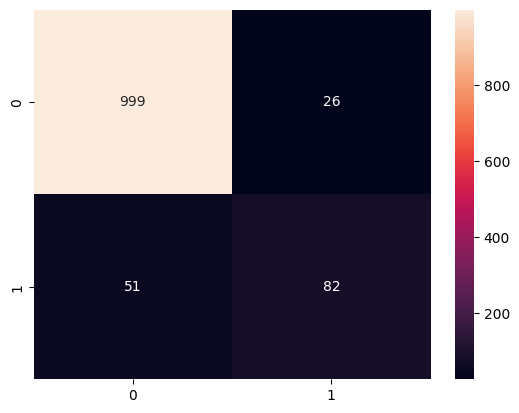

In [293]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='g');

## Can we Improve the Model?

* Our model is quite far from optimal and fine-tuning is really a benefit for the little increments to performance when your model is already performing well. However, we will try to improve performance
* We will use randomized search to vary a few of the parameters to see if we can tweak performance a little

In [298]:
model = RandomForestClassifier()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

* Scikit learn documentation suggests that the most important parameters are the max_depth and n_estimators
* We will tune a few parameters:
    * n_estimators = number of trees in the foreset
    * max_features = max number of features considered for splitting a node
    * max_depth = max number of levels in each decision tree
    * min_samples_split = min number of data points placed in a node before the node is split
    * min_samples_leaf = min number of data points allowed in a leaf node
    * bootstrap = method for sampling data points (with or without replacement)

In [300]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features at each split of a node
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [301]:
# Create the random grid - 
## per https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [307]:
# Run randomized search over the parameters
model_grid = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose=2, random_state=42,
                                scoring = 'f1',n_jobs = -1)
model_grid.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='f1', verbose=2)

In [308]:
# Get the best parameters
model_grid.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [309]:
# Best f1 score
model_grid.best_score_

0.7190668589239048

* We have improved the f1 score a little using hyperparameter tuning

In [310]:
# Build a model with best parameters
clf_best = RandomForestClassifier(n_estimators = 600, 
                                  min_samples_split = 5, 
                                  max_features = 'sqrt', 
                                  max_depth = 60, 
                                  bootstrap = False)
clf_best.fit(X_train, y_train)
coefs = pd.DataFrame(clf_best.feature_importances_)
coefs.index = X_train.columns

In [313]:
# Predict using the best model
y_pred_best = pd.DataFrame(clf_best.predict(X_test))
y_pred_best.head()

,0
0,0
1,0
2,0
3,1
4,0


In [315]:
# Check the classification report
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1025
           1       0.79      0.65      0.72       133

    accuracy                           0.94      1158
   macro avg       0.87      0.82      0.84      1158
weighted avg       0.94      0.94      0.94      1158



The f1 score has increased a little for both classes

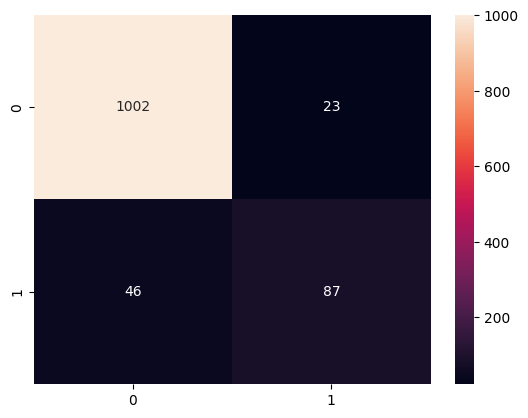

In [316]:
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot = True, fmt='g');

* Our model has correctly predicted 87 of the 133 test instances of a sale
* The model failed to predict a sale for the remaining 46 visitors who did buy

In [320]:
# Sorted coefficients
coefs.sort_values(by = 0, ascending = False).head(15)

,0
PageValues,0.48
ExitRates,0.07
ProductRelated_Duration,0.07
ProductRelated,0.05
Administrative_Duration,0.04
BounceRates,0.04
Administrative,0.03
Informational_Duration,0.01
Informational,0.01
VisitorType_Returning_Visitor,0.01


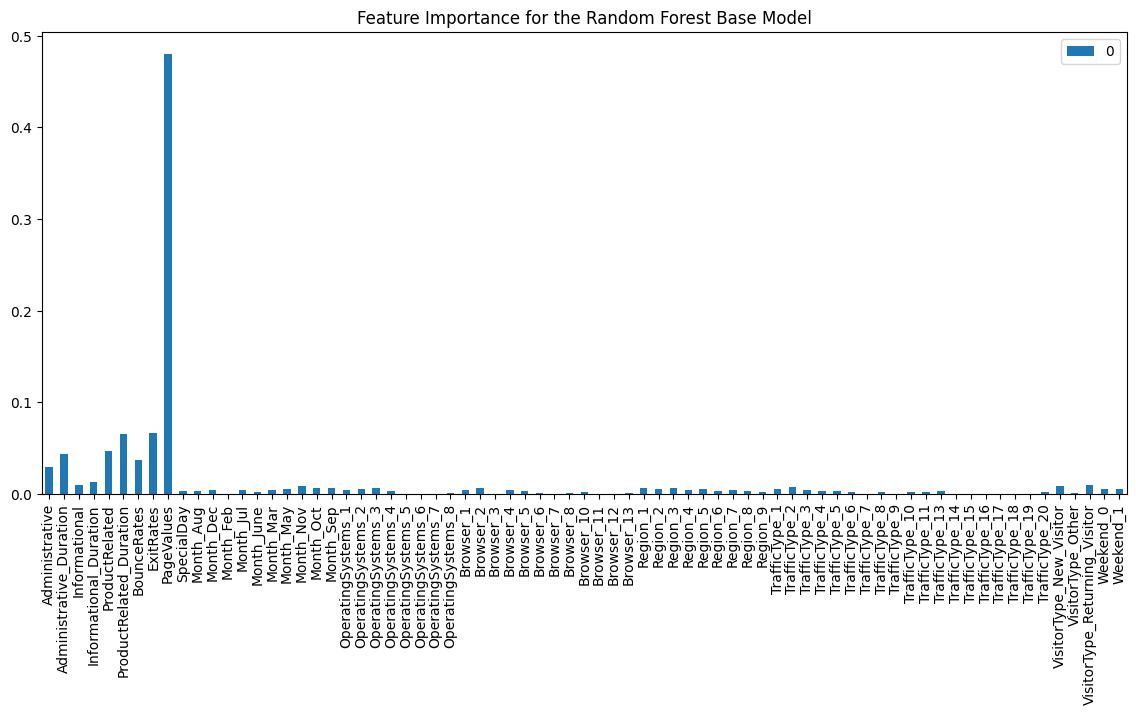

In [317]:
coefs.plot(kind = 'bar', figsize = (14,6))
plt.title("Feature Importance for the Random Forest Base Model");

* The most important feature is page values which is defined as the number of pages visited before making a sale
* Other features with some importance are duration spent on product related pages, exit rates, number of product related pages viewed and the number of pages and duration spent on administrative pages.
* These seem to be the most likely to have an influence on whether a visitor buys based on our previous analysis in notebook 1 also.
* Many of the categorical features have little to no impact on whether a sale is made based on the coefficients of the model